#Task - 2 (AI / ML)
##High contrast and low contrast color image classification
####Hello team,
####I have used VOC2007 original dataset for this task as dataset was not available, I created the dataset by changing the contrast of the images in original dataset and stored them to use as training as well as testing images.

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D,Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import glob
import random
from keras.utils.vis_utils import plot_model

###Creating different directories to store data

In [ ]:
os.mkdir("/content/drive/MyDrive/Task_Logictrix/dataset")
os.mkdir("/content/drive/MyDrive/Task_Logictrix/dataset/low")
os.mkdir("/content/drive/MyDrive/Task_Logictrix/dataset/high")

In [ ]:
count = 0
for i in glob.glob("/content/drive/MyDrive/Task_Logictrix/JPEGImages/*"):
  count += 1

print("Total images available are",count)

Total images available are 4398


###Converting regular image to low contrast image and storing it in directory named "low"

In [ ]:
count = 0
for i in glob.glob("/content/drive/MyDrive/Task_Logictrix/JPEGImages/*"):
  im = Image.open(i)
  enhancer = ImageEnhance.Contrast(im)
  im_out = enhancer.enhance(random.uniform(0.1,0.5))
  im_out.save(f"/content/drive/MyDrive/Task_Logictrix/dataset/low/{count}.jpg")
  count += 1

###Converting regular image to high contrast image and storing it in directory named "High"

In [ ]:
count = 0
for i in glob.glob("/content/drive/MyDrive/Task_Logictrix/JPEGImages/*"):
  im = Image.open(i)
  enhancer = ImageEnhance.Contrast(im)
  im_out = enhancer.enhance(random.uniform(1.5,2.0))
  im_out.save(f"/content/drive/MyDrive/Task_Logictrix/dataset/high/{count}.jpg")
  count += 1

In [ ]:
high = 0
low = 0
for i in glob.glob("/content/drive/MyDrive/Task_Logictrix/dataset/high/*"):
  high += 1

for i in glob.glob("/content/drive/MyDrive/Task_Logictrix/dataset/low/*"):
  low += 1

print("Total number of high contrast images are",high)
print("Total number of low contrast images are",low)

Total number of high contrast images are 4398
Total number of low contrast images are 4398


###Selecting "dataset" directory as Base directory

In [5]:
BASE_DIR = "/content/drive/MyDrive/Task_Logictrix/dataset/"
os.listdir(BASE_DIR)

['low', 'high']

###Creating training as well as validation data using **(80 / 20)** ratio and selecting 32 as batch size and **(320,320)** as input image size.
###**image_dataset_from_directory** automatically creates labels for us.

In [6]:
batch_size = 32
image_size = (320,320)
train_ds = image_dataset_from_directory(
    BASE_DIR,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = "training",
)
val_ds = image_dataset_from_directory(
    BASE_DIR,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = "validation",
)

Found 8796 files belonging to 2 classes.
Using 7037 files for training.
Found 8796 files belonging to 2 classes.
Using 1759 files for validation.


###Some training dataset images with their labels generated by tensorflow

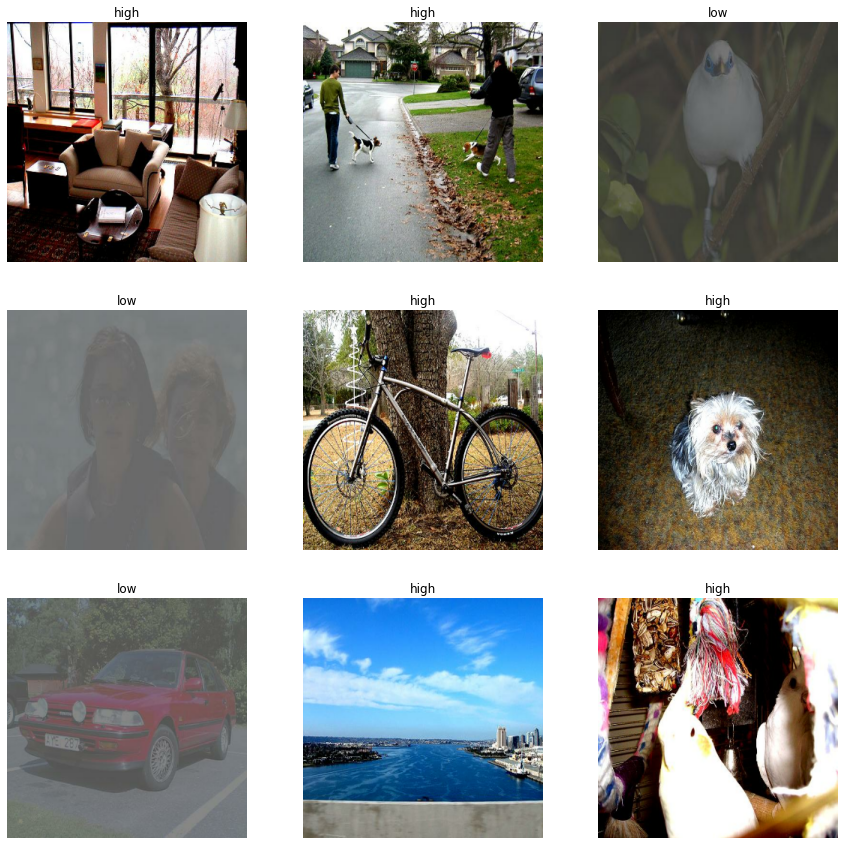

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

###Using prefetch to save next batches of images in cache memory so that execution can be made faster.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

###Preprocessing image data by dividing each pixel by 255 so that neural network can easily find pattern.

In [11]:
normalize_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
train_ds = train_ds.map(lambda x,y: (normalize_layer(x),y))
val_ds = val_ds.map(lambda x,y: (normalize_layer(x), y))

##Model Building.
###In this phase I have created simple Convolution neural network model.

In [ ]:
def create_model(input_shape = (320,320,3)):
  x_input = Input(input_shape)
  x = ZeroPadding2D((3,3))(x_input)

  x = Conv2D(filters=16,kernel_size=(3,3),padding="same")(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size=(2,2))(x)

  x = Conv2D(filters=32,kernel_size=(3,3),padding="same")(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size=(2,2))(x)

  x = Conv2D(filters=64,kernel_size=(3,3),padding="same",kernel_regularizer=tf.keras.regularizers.l1_l2())(x) # Adding regularization to handle overfitting
  x = BatchNormalization(axis=3)(x)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size=(2,2))(x)

  x = Flatten()(x)
  x = Dense(units=128, activation="relu")(x)
  x = Dropout(0.4)(x) # Adding dropout layer to handle overfitting
  x = Dense(units = 2)(x)

  mod = Model(inputs=x_input, outputs=x)
  return mod

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 326, 326, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 326, 326, 16)      448       
_________________________________________________________________
batch_normalization_13 (Batc (None, 326, 326, 16)      64        
_________________________________________________________________
activation_13 (Activation)   (None, 326, 326, 16)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 163, 163, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 163, 163, 32)      4640

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

In [ ]:
epochs = 5
history = model.fit(
    train_ds,
    epochs=epochs
)

Epoch 1/5
220/220 [==============================] - 1301s 164ms/step - loss: 6.7268 - accuracy: 0.9827
Epoch 2/5
220/220 [==============================] - 35s 160ms/step - loss: 1.9831 - accuracy: 0.9926
Epoch 3/5
220/220 [==============================] - 35s 160ms/step - loss: 0.6660 - accuracy: 0.9893
Epoch 4/5
220/220 [==============================] - 35s 161ms/step - loss: 0.5830 - accuracy: 0.9875
Epoch 5/5
220/220 [==============================] - 35s 160ms/step - loss: 0.3681 - accuracy: 0.9868


In [ ]:
test_history = model.evaluate(val_ds)

55/55 [==============================] - 457s 7s/step - loss: 0.5909 - accuracy: 0.9807


###Saving model for next time usage of it.

In [ ]:
model.save("/content/drive/MyDrive/Task_Logictrix/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Task_Logictrix/assets


In [7]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Task_Logictrix/")

##Convolutional neural network(CNN) model working very good and giving accuracy around 99.86% on training data.
###Plot showing training accuracy with each epoch.

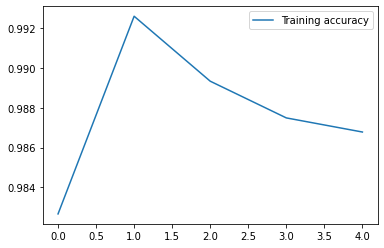

In [ ]:
train_acc = []
train_acc += history.history["accuracy"]
plt.plot(train_acc,label="Training accuracy")
plt.legend()

In [8]:
batch_size = 32
image_size = (320,320)
experiment_ds = image_dataset_from_directory(
    BASE_DIR,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = "training",
)

Found 8796 files belonging to 2 classes.
Using 7037 files for training.


In [13]:
normalize_exp_ds = experiment_ds.map(lambda x,y : (normalize_layer(x),y))

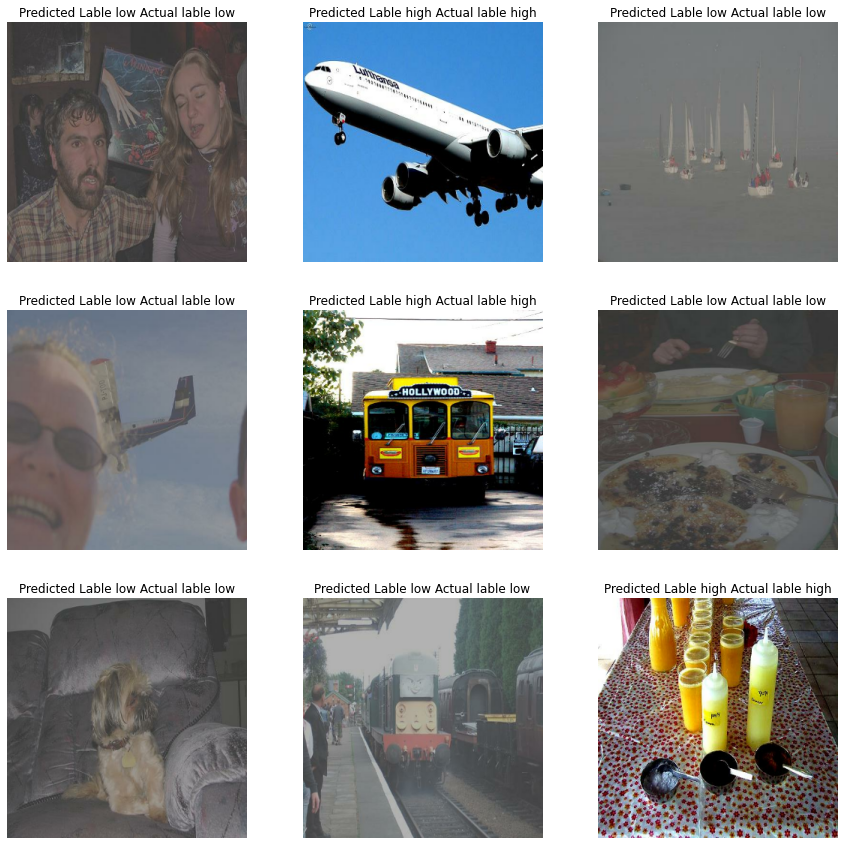

In [15]:
plt.figure(figsize=(15, 15))
for images, labels in experiment_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Predicted Lable "+ experiment_ds.class_names[np.argmax(model.predict((images[i].numpy().reshape((1,320,320,3))) / 255.))] +" Actual lable "+  experiment_ds.class_names[labels[i]],fontsize = 12)
        plt.axis("off")

###Image of neural network model

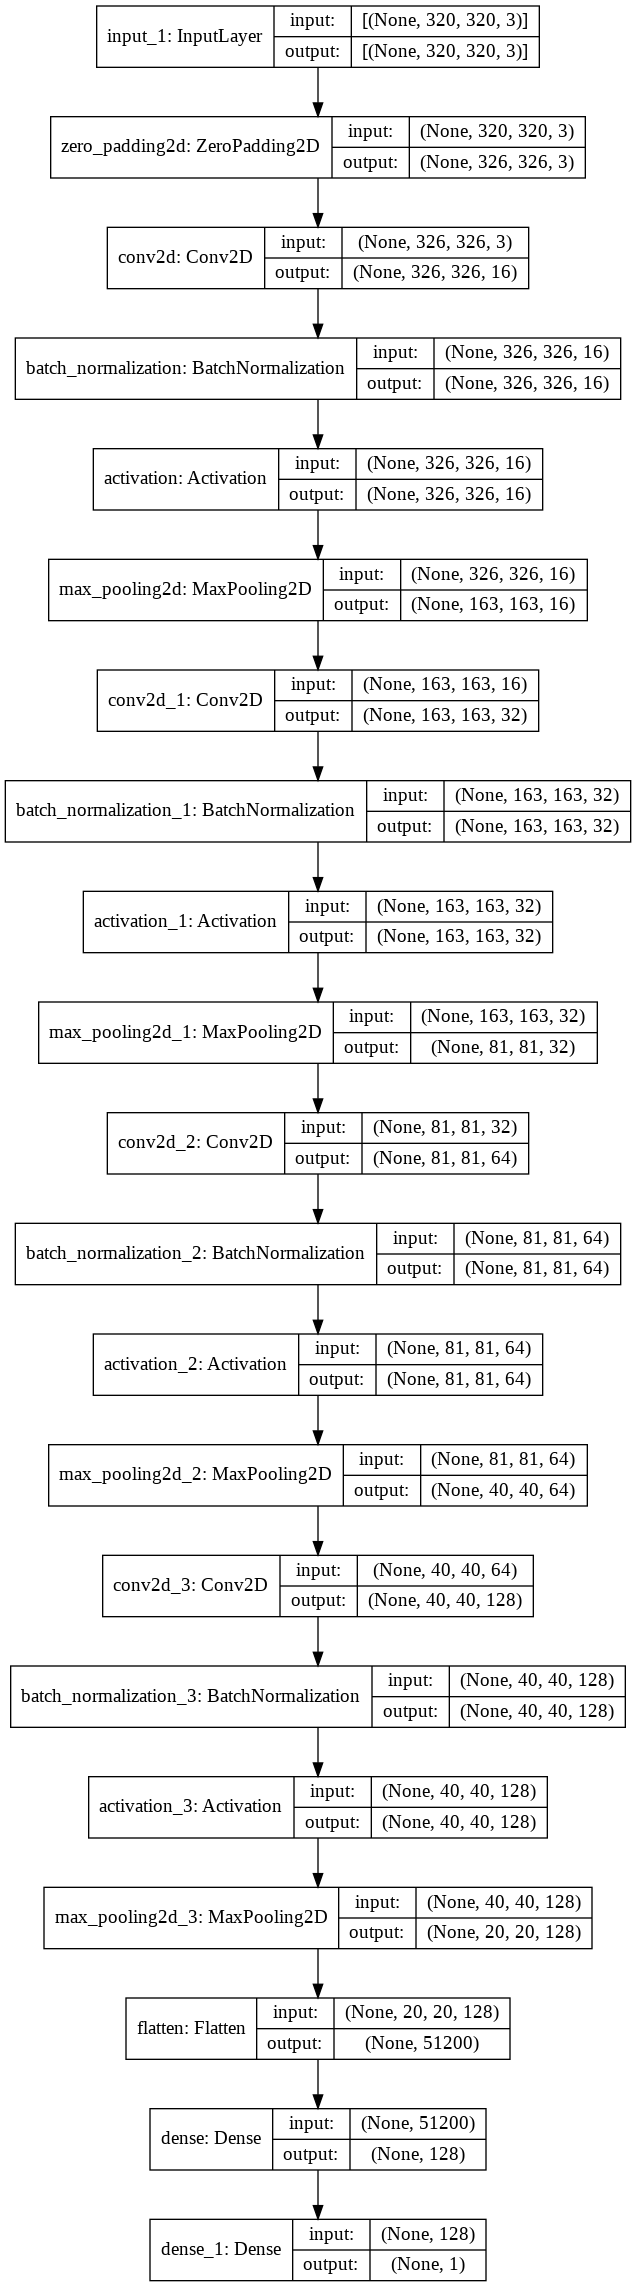

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

#Transfer learning
##As most of the tasks in **Machine learning** and **deep learning** are complex its good to head start quickly by using pretrained model and finetune them as our requirments.

##Using MobileNetV2 model for transfer learning and downloading weights of **imagenet** dataset which are pretrained.

In [16]:
ip_shape = (320,320,3)

base_model = tf.keras.applications.MobileNetV2(
    input_shape = ip_shape,
    include_top = False,
    weights = "imagenet"
)

9420800/9406464 [==============================] - 0s 0us/step


##Exploring MobileNetV2 model

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 160, 160, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 160, 160, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 160, 160, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

##Perparing dataset for MobileNetV2 model

In [20]:
batch_size = 32
image_size = (320,320)
train_ds = image_dataset_from_directory(
    BASE_DIR,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = "training",
)
val_ds = image_dataset_from_directory(
    BASE_DIR,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = "validation",
)

Found 8796 files belonging to 2 classes.
Using 7037 files for training.
Found 8796 files belonging to 2 classes.
Using 1759 files for validation.


In [21]:
base_model.trainable =  True

In [ ]:
len(base_model.layers)

##As their are 154 layers in base_model starting fine tuning the model from layer number 100 so that, layers after 100 will be trained on our dataset and before 100 layers all the layers will be freezed so that computation time decreases.

In [22]:
fine_tune = 100

for layer in base_model.layers[:fine_tune]:
  layer.trainable = False

##As MobileNetV2 uses different preprocessing on images adding preprocessing layer for that model

In [19]:
normalization = tf.keras.layers.experimental.preprocessing.Rescaling(1 / 127.5, offset = -1)

#Model Creation
##Creating model as requirment with the help of **base_model (MobileNetV2)**

In [25]:
def create_model(input_shape = (320,320,3)):

  input = layers.Input(shape = input_shape)
  x = normalization(input)
  x = base_model(x, training = False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(2)(x)

  model = tf.keras.Model(input, x)
  return model

In [26]:
model2 = create_model()

In [27]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 320, 320, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,864,002
Non-trainable params: 396,544
_____________________________________________

In [28]:
model2.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

In [ ]:
history = model2.fit(
    train_ds,
    epochs = 5
)

Epoch 1/5
220/220 [==============================] - 1050s 5s/step - loss: 0.7751 - accuracy: 0.5004
Epoch 2/5
220/220 [==============================] - 557s 3s/step - loss: 0.7040 - accuracy: 0.4981
Epoch 3/5
220/220 [==============================] - 551s 3s/step - loss: 0.8085 - accuracy: 0.4930
Epoch 4/5
138/220 [=================>............] - ETA: 3:23 - loss: 0.7700 - accuracy: 0.4885

###As model is not giving result as we want so therefor, I stopped training to check which things go wrong but as a time constraint I could not check the following things


*   Try different pretrained models
*   Apply fine tuning at different levels
*   Tune different hyperparameters etc.



##Thanks for viewing and checking my work I hope you like it.
##I have experience in working with **Images(CNN)** and **Text(RNN or Sequence models)** and have good knowledge of different machine learning algorithms and knows how they work under the hood.
##I am keen and excited to work in real time projects and wants to grow more and more and acquire as much knowledge as I can.
##I have done many projects in machine learning and deep learning which can be viewed at **https://github.com/sagar27012001/**
#Thank you.